<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<hr>

<br>

# Metop-B IASI carbon monoxide (CO) - Longterm time-series

### About

The [Infrared Atmospheric Sounding Interferometer (IASI)](https://www.eumetsat.int/website/home/Satellites/CurrentSatellites/Metop/MetopDesign/IASI/index.html) is an instrument onboard the Metop-B/C satellites. It was also aboard the Metop-A satellite until 2020. It provides information on the vertical structure of temperature and humidity as well as main atmospheric species.

This notebook provides you an introduction to Carbon Monoxide Level 3 data from Metop-B IASI and guides you through the steps to compute a longterm time series of CO.

### Basic Facts

> **Spatial resolution**: `1° x 1°` <br>
> **Spatial coverage**: `Near global` <br>
> **Revisit time**:  `Monthly` <br>
> **Data availability**: `since 2013`


### How to access the data

IASI Level 3 are disseminated in the `netCDF` format and can be downloaded via the [IASI portal](https://iasi.aeris-data.fr/).

### Module outline 
* [Load Metop-B IASI Level 3 data from March 2013 to July 2022](#level3)
* [Retrieve the variable 'COgridDAY' as xarray.DataArray](#data_retrieve_iasi)
* [Convert units of Total Column Carbon Monoxide data](#convert_units_iasi)
* [Create (longterm) spatial mean of total column CO](#longterm_mean)
* [Visualize (longterm) total column CO ](#visualize)

<hr>

### Load required libraries

In [1]:
import os

import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime

# Python libraries for visualization
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm as cm
from matplotlib.axes import Axes

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [3]:
%run ./functions.ipynb

<hr>

## <a id='region_list'></a>Define a list with dictionaries holding bounding boxes for different regions

You can define several regions as a dictionary, e.g. the bounding box information for a `Global average`, `Southern Hemisphere` and `Northern Hemisphere`. The dictionaries are stored in a list.

In [4]:
# Global extent
global_extent={'name': 'global_extent',
            'lonmin':-180.0,
            'lonmax':180.0,
            'latmin':-90.0,
            'latmax':90.0}

# Southern Hemisphere extent
sh_extent={'name': 'sh_extent',
            'lonmin':-180.0,
            'lonmax':180.0,
            'latmin':-90.0,
            'latmax':0}

# Northern Hemisphere extent
nh_extent={'name': 'nh_extent',
            'lonmin':-180.0,
            'lonmax':180.0,
            'latmin':0,
            'latmax':90.0}

region_list=[global_extent,
             sh_extent,
             nh_extent]

## <a id='level3'></a>Load Metop-B IASI Level 3 data from March 2013 to July 2022

Global Metop-B IASI Level 3 data are available from March 2013 to July 2022. From this longterm time-series, you can create a spatial average of a specific region and visualize the monthly total column CO content over time.

#### Load the Metop-B IASI Level 3 data files as `xarray.DataArray` with the function `xarray.open_mfdataset()`

The Metop-B IASI Level 3 data are disseminated in `netCDF`. The function `xarray.open_mfdataset()` can be used to load the data for all months at once. Use `time` for the keyword argument `concat_dim`.

In [5]:
iasi_l3 = xr.open_mfdataset('../eodata/training_school/iasi/level3/co/co-metop-b/*.nc', concat_dim='time', combine='nested')
iasi_l3

<xarray.Dataset>
Dimensions:         (latitude: 180, longitude: 360, time: 113)
Coordinates:
  * latitude        (latitude) float32 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * longitude       (longitude) float32 -179.5 -178.5 -177.5 ... 178.5 179.5
Dimensions without coordinates: time
Data variables:
    COgridDAY       (time, longitude, latitude) float32 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
    COgridNIGHT     (time, longitude, latitude) float32 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
    ErrorgridDAY    (time, longitude, latitude) float32 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
    ErrorgridNIGHT  (time, longitude, latitude) float32 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
Attributes: (12/32)
    title:                                   Monthly IASI/Metop-B ULB-LATMOS ...
    institution:                             LATMOS
    product_version:                         20151001.0
    history:                                 2020-11-19 16:40:39 - Product ge...
    summary:                                 This dataset contains Level 3 ca...
    source:                                  ULB-LATMOS IASI Level 2 carbon m...
    ...                                      ...
    sensor:                                  IASI
    spatial_resolution:                      grid: 1 deg x 1 deg
    creator_type:                            institution
    creator_name:                            LATMOS
    contact_email:                           contact form at http://iasi.aeri...
    data_policy:                             see https://iasi.aeris-data.fr/d...

#### Assign coordinates to the dimensions `latitude`, `longitude` and `time`

You can use the function `pandas.data_range` from the pandas library to build a list of monthly time coordinates from March 2013 to July 2022.

In [6]:
# Build list of time coordinates with pandas
time_coords = pd.date_range('2013-03', '2022-07', freq='MS').strftime("%Y-%m").astype('datetime64[ns]')
time_coords

DatetimeIndex(['2013-03-01', '2013-04-01', '2013-05-01', '2013-06-01',
               '2013-07-01', '2013-08-01', '2013-09-01', '2013-10-01',
               '2013-11-01', '2013-12-01',
               ...
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01'],
              dtype='datetime64[ns]', length=113, freq=None)

Use the function `xarray.assign_coords()` to assign `time` coordinates to the `iasi_l3` `xarray.Dataset` above.

In [7]:
# Assign values to Dataset dimension
iasi_l3_assigned = iasi_l3.assign_coords(time=time_coords)
iasi_l3_assigned

<xarray.Dataset>
Dimensions:         (latitude: 180, longitude: 360, time: 113)
Coordinates:
  * latitude        (latitude) float32 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * longitude       (longitude) float32 -179.5 -178.5 -177.5 ... 178.5 179.5
  * time            (time) datetime64[ns] 2013-03-01 2013-04-01 ... 2022-07-01
Data variables:
    COgridDAY       (time, longitude, latitude) float32 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
    COgridNIGHT     (time, longitude, latitude) float32 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
    ErrorgridDAY    (time, longitude, latitude) float32 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
    ErrorgridNIGHT  (time, longitude, latitude) float32 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
Attributes: (12/32)
    title:                                   Monthly IASI/Metop-B ULB-LATMOS ...
    institution:                             LATMOS
    product_version:                         20151001.0
    history:                                 2020-11-19 16:40:39 - Product ge...
    summary:                                 This dataset contains Level 3 ca...
    source:                                  ULB-LATMOS IASI Level 2 carbon m...
    ...                                      ...
    sensor:                                  IASI
    spatial_resolution:                      grid: 1 deg x 1 deg
    creator_type:                            institution
    creator_name:                            LATMOS
    contact_email:                           contact form at http://iasi.aeri...
    data_policy:                             see https://iasi.aeris-data.fr/d...

## <a id='data_retrieve_iasi'></a>Retrieve the variable 'COgridDAY' as xarray.DataArray

Now you can take a load the daytime CO data using the square brackets.

In [8]:
iasi_co_day = iasi_l3_assigned['COgridDAY']
iasi_co_day

<xarray.DataArray 'COgridDAY' (time: 113, longitude: 360, latitude: 180)>
dask.array<concatenate, shape=(113, 360, 180), dtype=float32, chunksize=(1, 360, 180), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time       (time) datetime64[ns] 2013-03-01 2013-04-01 ... 2022-07-01
Attributes:
    long_name:                                             weighted average o...
    units:                                                 mol m-2
    multiplication_factor_to_convert_to_molecules_percm2:  6.02214179e+19
    vertical_range_bottom:                                 surface
    vertical_range_top:                                    60.0_km
    comment:                                               daytime observatio...

## <a id='convert_units_iasi'></a>Convert units of Total Column Carbon Monoxide data

Per default, the data is disseminated in the CF-convention unit `mol/m2`, but total column CO values are often represented in the unit `mol/cm2`. Hence, in a next step, you need to convert the data from `mol/m2` to `molecules/cm2`. The loaded data variable `COgridDAY` has an attribute called `multiplication_factor_to_convert_to_molecules_per_cm2`, which is used to convert the data values.

In [9]:
iasi_co_converted  = iasi_co_day * iasi_co_day.multiplication_factor_to_convert_to_molecules_percm2
iasi_co_converted 

<xarray.DataArray 'COgridDAY' (time: 113, longitude: 360, latitude: 180)>
dask.array<mul, shape=(113, 360, 180), dtype=float32, chunksize=(1, 360, 180), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time       (time) datetime64[ns] 2013-03-01 2013-04-01 ... 2022-07-01

## <a id='longterm_mean'></a> Create (longterm) spatial mean of total column CO

Let us loop through the list of regions and create a dictionary containing these lists:
- **co_l3**: the spatial average for each month of total column CO of the specific region, and
- **co_monthly_avg**: the longterm mean (climatology) of total column CO of each month
- **co_yearly_avg**: the annual mean of total column CO of each year

The loop makes use of the function [generate_geographical_subset](../functions.ipynb#geographical_subset), which creates a smaller spatial subset based on the bounding box information of each region.

The spatial average of a `xarray.DataArray` is computed with the function `xarray.DataArray.mean()`, for which you have to specify the dimension(s) overwhich the spatial average shall be computed, e.g. `dim=['latitude', 'longitude']`.

The longterm average is retrieved by using xarray's `groupby('time.month').mean()` aggregator.

In [10]:
# Retrieve the tropospheric co from the xarray Dataset
co_l3 = iasi_co_converted

# Initialise an empty dictionary
iasi_l3_dict = {}

# Loop through each item in region list
for region in region_list:
    print(region)
    # Generate a geographical subset
    tmp = generate_geographical_subset(xarray=co_l3,
                                       latmin=region['latmin'],
                                       latmax=region['latmax'],
                                       lonmin=region['lonmin'],
                                       lonmax=region['lonmax'])
    # Create the spatial average of the region
    tmp_mean = tmp.mean(dim=['latitude','longitude'])
    # Create the longterm climatology of each month
    tmp_climatology_mean = tmp_mean.groupby('time.month').mean()
    # Create the annual average of each year
    tmp_annual_mean = tmp_mean.groupby('time.year').mean()
    # Fill the dictionary with the lists
    iasi_l3_dict[region['name']]={'co_l3':tmp_mean,
                                  'co_monthly_avg': tmp_climatology_mean,
                                  'co_yearly_avg': tmp_annual_mean}


{'name': 'global_extent', 'lonmin': -180.0, 'lonmax': 180.0, 'latmin': -90.0, 'latmax': 90.0}
{'name': 'sh_extent', 'lonmin': -180.0, 'lonmax': 180.0, 'latmin': -90.0, 'latmax': 0}
{'name': 'nh_extent', 'lonmin': -180.0, 'lonmax': 180.0, 'latmin': 0, 'latmax': 90.0}


The resulting dictionary contains the three regions as keys and for each region, you can retrieve the time series and climatology of total column CO.

In [11]:
iasi_l3_dict['nh_extent']['co_l3']

<xarray.DataArray 'COgridDAY' (time: 113)>
dask.array<mean_agg-aggregate, shape=(113,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2013-03-01 2013-04-01 ... 2022-07-01

## <a id='visualize'></a>Visualize (longterm) total column CO 

### <a id='plot_level3_ts'></a>Plot the total column CO time-series (2013 to 2022) for for a Global average, Southern Hemisphere and Northern Hemisphere.

Let us visualize the total column CO time-series from 2013 to 2022. You can make use of the `xarray.DataArray.plot.line()` function. As dictionary key, you select for each region the `co_l3` time-series.

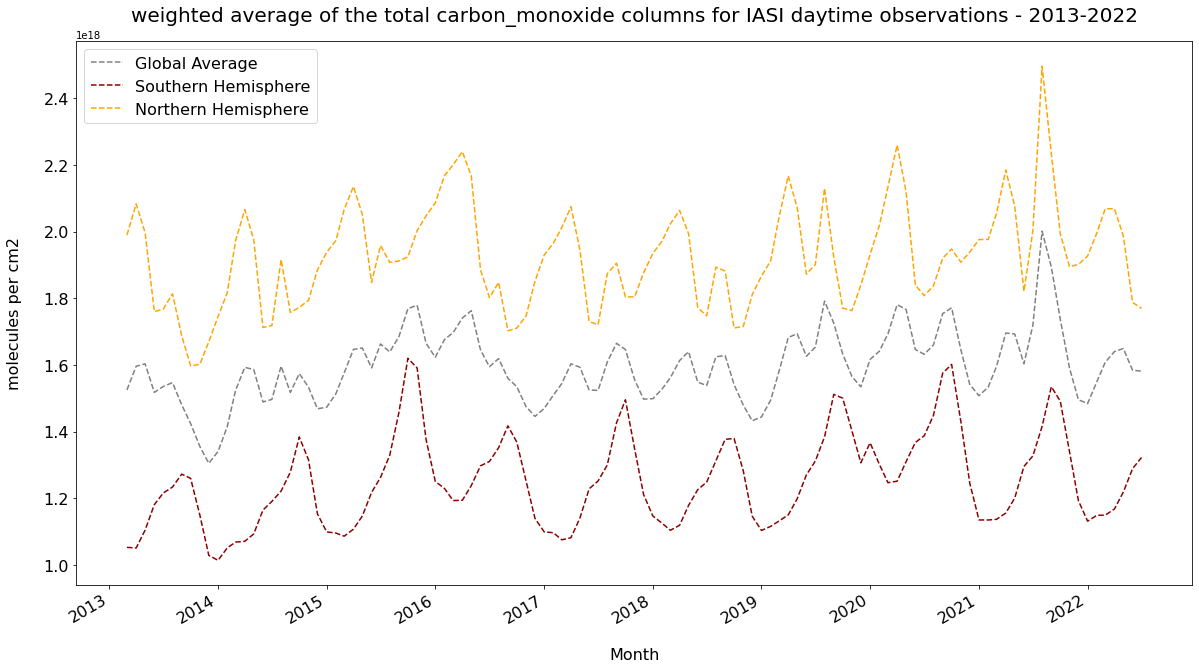

In [14]:
fig = plt.figure(figsize=(20,10))

(iasi_l3_dict['global_extent']['co_l3']).plot.line(
    linestyle='dashed',
    color='grey', 
    label='Global Average')

(iasi_l3_dict['sh_extent']['co_l3']).plot.line(
    linestyle='dashed',
    color='darkred', 
    label='Southern Hemisphere')

(iasi_l3_dict['nh_extent']['co_l3']).plot.line(
    linestyle='dashed',
    color='orange',
    label='Northern Hemisphere')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(iasi_co_day.long_name + " - 2013-2022", fontsize=20, pad=20)

plt.ylabel('molecules per cm2\n' , fontsize=16)
plt.xlabel('\nMonth', fontsize=16)
plt.legend(fontsize=16,loc=0)
plt.show()

### <a id='plot_climatology'></a> Plot longterm total column CO climatology for a Global average, Southern Hemisphere and Northern Hemisphere.

Let us now visualize the total column CO climatology for each month (based on the 2013 to 2022 time-series). You can make use of the `xarray.DataArray.plot.line()` function. As dictionary key, you select for each region the `co_monthly_avg` time-series.

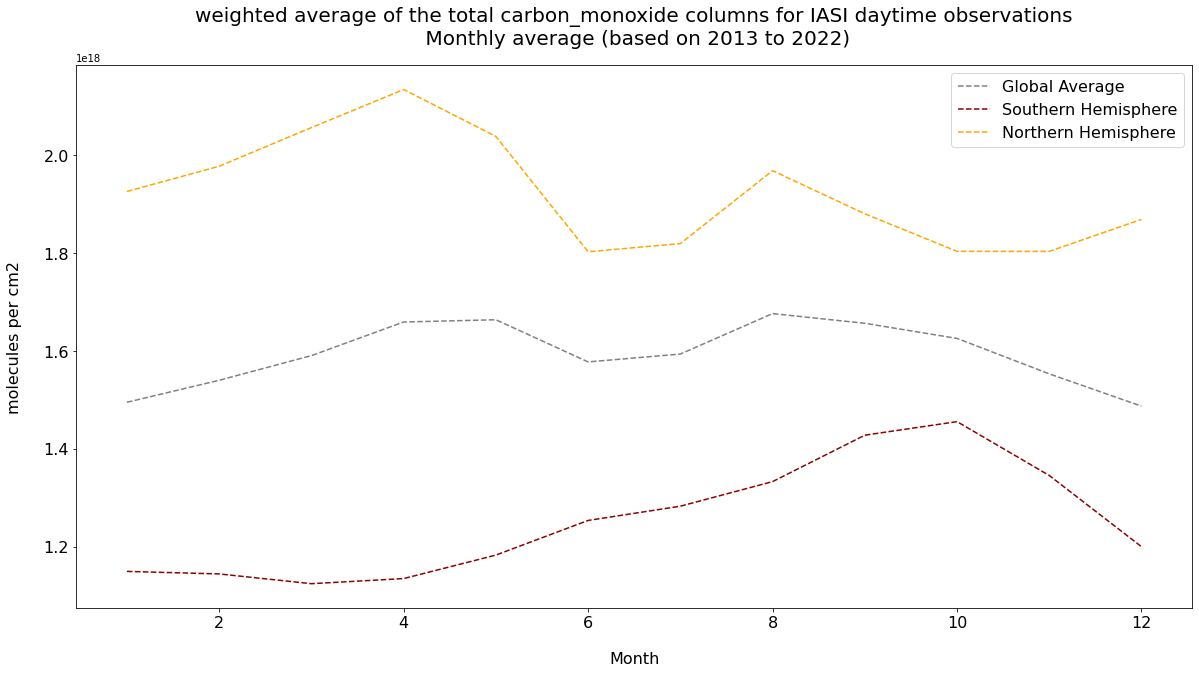

In [15]:
fig = plt.figure(figsize=(20,10))

(iasi_l3_dict['global_extent']['co_monthly_avg']).plot.line(
    linestyle='dashed',
    color='grey', 
    label='Global Average')

(iasi_l3_dict['sh_extent']['co_monthly_avg']).plot.line(
    linestyle='dashed',
    color='darkred', 
    label='Southern Hemisphere')

(iasi_l3_dict['nh_extent']['co_monthly_avg']).plot.line(
    linestyle='dashed',
    color='orange', 
    label='Northern Hemisphere')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title(iasi_co_day.long_name + "\n Monthly average (based on 2013 to 2022)", fontsize=20, pad=20)
plt.ylabel('molecules per cm2\n' , fontsize=16)
plt.xlabel('\nMonth', fontsize=16)
plt.legend(fontsize=16,loc=1)
plt.show()

## <a id='visualize_bar_plot'></a>Visualize global average annual time-series of total column CO values from 2013 to 2022 as a bar plot

First, you can convert the xarray.DataArray with the annual mean climatology into a Pandas series using `.to_series`. This enables you to plot the data as a bar plot with the function `plot.bar()`.

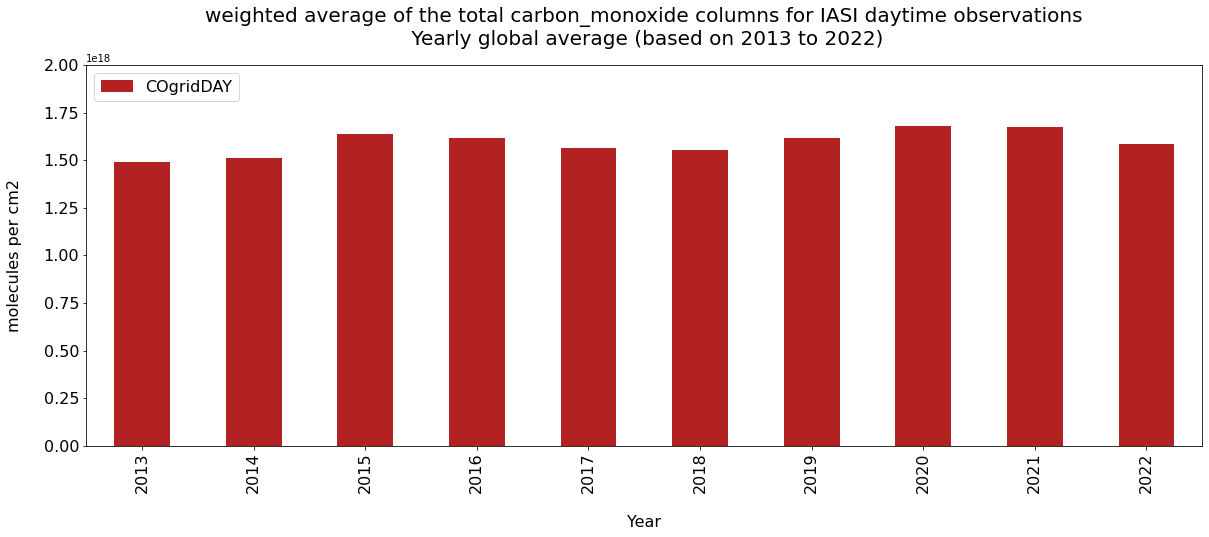

In [16]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(20,7))

co_series = (iasi_l3_dict['global_extent']['co_yearly_avg']).to_series()

co_series.plot.bar( 
    ax=ax, 
    color='firebrick')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_ylim(0,2e+18)

plt.title(iasi_co_day.long_name + "\n Yearly global average (based on 2013 to 2022)", fontsize=20, pad=20)
plt.ylabel('molecules per cm2\n' , fontsize=16)
plt.xlabel('\nYear', fontsize=16)
plt.legend(fontsize=16,loc=2)
plt.show()

<hr>

<p><img src='./img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a>.</p>